In [13]:
from datetime import datetime
import automlShortForecast.util_2 as util
import pandas as pd
from sklearn import linear_model
from matplotlib import pyplot as plt
import pickle
from poseidon import poseidon
import time
import hashlib
import pandas as pd
import argparse
import mlflow
import mlflow.sklearn

In [14]:
#from sklearn.externals import joblib
millis = int(round(time.time() * 1000))
#授权应用的accessKey
accessKey = 'a3358652-483d-4e6a-973e-f0e49d445a4e'
#授权应用的secretKey
secretKey = 'c8585cde-85c3-4735-97a1-18141366c4df'
#token将在get_token方法中通过APIM接口进行获取
token = ''
#IAM地址
base = 'https://beta-apim-cn4.eniot.io/data-federation/v2.0/channels/read/'
#base = 'https://beta-portal-cn4.eniot.io:8081/data-federation/v2.0/channels/read/'
#访问通道ID
channel = 'ch-4cb5c2'
#组织ID
orgId = 'o15632609593521'
url = base + channel + '?orgId=' + orgId

In [15]:
#Get Token
#global token
url1 = 'https://beta-apim-cn4.eniot.io/apim-token-service/v2.0/token/get'
hash = hashlib.sha256()
hash.update((accessKey+str(millis)+secretKey).encode('utf-8'))
data = {"appKey": accessKey, "encryption": hash.hexdigest(), "timestamp":millis}
req = poseidon.urlopen(accessKey, secretKey, url1, data)
token = req.get('data').get('accessToken')
print(token)

2a7fa9013a9cae2f57ffa103138af7a8bae8b2875658255df8ace04d2a53ed0b


In [20]:
def querytables(query_str):
    header={'Content-Type':'application/json','Authorization':'Bearer ' + token}

    data = {"sqlQuery": query_str, "queue": None, "itemFormat": None}
    req = poseidon.urlopen(accessKey, secretKey, url, data, header)
    return pd.DataFrame(req.get('data').get('rows'))

query_kmmlds91x='''
select * from df_hive.data_o15632609593521.`kmmlds1` where masterid='ABCDE0001' and sequence<=26000
'''
query_kmmlds91y='''
select sequence,power,speed from df_hive.data_o15632609593521.`kmmlds1` where masterid='ABCDE0001' and sequence<=26000
'''
x_df=querytables(query_kmmlds91x)
x_df.drop(['speed','power'],axis=1,inplace=True)
y_df=querytables(query_kmmlds91y)

In [21]:
x_df

,x_basic_time,ec_ws,ec_rho,gfs_nwp_time,x_basic_forecast_time,ec_dist,gfs_dist,gfs_wd,x_basic_horizon,ec_tmp,...,gfs_ws,gfs_press,masterid,ec_wd,i_set,ec_press,ec_nwp_time,x_basic_hour,gfs_tmp,gfs_rho
0,2018-07-01T00:00,5.584500,1.152237,2018-06-30T12:00,2018-07-01T00:00,12.0,12.0,218.53998,0.0,27.827000,...,5.6870,987.24,ABCDE0001,221.91003,0.0,995.4800,2018-06-30T12:00,0.0,29.450,1.136570
1,2018-07-01T01:00,5.054566,1.148961,2018-06-30T12:00,2018-07-01T00:00,13.0,13.0,220.27002,1.0,28.667000,...,6.0588,987.41,ABCDE0001,217.49670,0.0,995.4200,2018-06-30T12:00,1.0,30.399,1.133212
2,2018-07-01T02:00,4.524633,1.145703,2018-06-30T12:00,2018-07-01T00:00,14.0,14.0,221.65002,2.0,29.507000,...,5.9294,987.39,ABCDE0001,213.08331,0.0,995.3600,2018-06-30T12:00,2.0,31.112,1.130534
3,2018-07-01T03:00,3.994700,1.142463,2018-06-30T12:00,2018-07-01T00:00,15.0,15.0,220.58002,3.0,30.347000,...,5.5855,987.45,ABCDE0001,208.66998,0.0,995.3000,2018-06-30T12:00,3.0,31.835,1.127922
4,2018-07-01T04:00,4.593200,1.142332,2018-06-30T12:00,2018-07-01T00:00,16.0,16.0,218.66998,4.0,30.279000,...,5.5985,987.22,ABCDE0001,209.38666,0.0,994.9633,2018-06-30T12:00,4.0,32.095,1.126699
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19996,2019-08-13T04:00,5.859600,1.140263,2019-08-12T12:00,2019-08-13T00:00,16.0,16.0,246.28998,4.0,30.430334,...,3.8788,987.63,ABCDE0001,237.97998,408.0,993.6567,2019-08-12T12:00,4.0,33.167,1.123222
19997,2019-08-13T05:00,6.086200,1.139177,2019-08-12T12:00,2019-08-13T00:00,17.0,17.0,238.18000,5.0,30.559666,...,3.6215,987.33,ABCDE0001,228.12000,408.0,993.1333,2019-08-12T12:00,5.0,33.550,1.121479
19998,2019-08-13T06:00,6.312800,1.138093,2019-08-12T12:00,2019-08-13T00:00,18.0,18.0,227.01001,6.0,30.689000,...,4.7028,986.55,ABCDE0001,218.26001,408.0,992.6100,2019-08-12T12:00,6.0,33.782,1.119746
19999,2019-08-13T07:00,6.259800,1.138611,2019-08-12T12:00,2019-08-13T00:00,19.0,19.0,226.32000,7.0,30.470999,...,7.1361,986.03,ABCDE0001,222.15332,408.0,992.3500,2019-08-12T12:00,7.0,32.950,1.122197


In [19]:
y_df

,sequence,power,speed
0,0.0,14922.795737,5.546887
1,1.0,14333.692105,5.447009
2,2.0,16944.365172,5.847055
3,3.0,48099.875427,8.421027
4,4.0,33362.288034,7.452626
...,...,...,...
19996,19996.0,7026.217389,4.440820
19997,19997.0,13632.511088,5.470778
19998,19998.0,29820.623516,7.204107
19999,19999.0,53350.476192,8.850822


In [7]:
y_df.head(10)

,sequence,power,speed
0,0.0,14922.795737,5.546887
1,1.0,14333.692105,5.447009
2,2.0,16944.365172,5.847055
3,3.0,48099.875427,8.421027
4,4.0,33362.288034,7.452626
5,5.0,27854.329154,6.937523
6,6.0,23058.790535,6.589801
7,7.0,40081.336310,7.985483
8,8.0,34268.389178,7.477266
9,9.0,35652.579874,7.638879


In [22]:
def feature_clean(x_df, y_df=None, cleaning_x=True):
    if cleaning_x:
        if isinstance(x_df, pd.DataFrame):
            is_valid = x_df.notnull().all(axis=1)
            print(89, is_valid.shape)

        else:
            is_valid = x_df.notnull()
#             print(92, is_valid.shape)
    else:
        is_valid = pd.Series(np.ones(len(x_df), dtype=bool), index=x_df.index)
    if y_df is not None:
        if isinstance(y_df, pd.DataFrame):
            is_valid = is_valid & y_df.notnull().all(axis=1)
        else:
            is_valid = is_valid & y_df.notnull()
    x_clean = x_df.loc[is_valid]
#     print(99, x_clean.shape)
#     print(100, is_valid)
#     print(101, )
    if y_df is not None:
        y_clean = y_df.loc[is_valid]
        return x_clean, y_clean, is_valid
    else:
        return x_clean, is_valid

def data_prepare(x_df):
    x_df = util.polar_to_cart(x_df)
    x_df = util.add_feature_wdcut(x_df, n_sector=8, one_hot_encoding=True)
    x_df = util.add_feature_rho_crossed(x_df, '_ws')
    return x_df

def _1st_stacking_feature(nwp):
    input_feature = [nwp + '_ws_rho1', nwp + '_ws_rho2', nwp + '_ws_angles', nwp + '_ws',
                     nwp + '_wd', nwp + '_rho', nwp + '_dist', nwp + '_u', nwp + '_v']
    input_feature.extend(['{}_wd_cut_s{}'.format(nwp, n) for n in range(8)])
    output_feature = nwp + '_pre_ws'
    return input_feature, output_feature

def LinearModel():
    return linear_model.LinearRegression()

# PreprocessingLinearModel:
    original data preprocessing and training
    input:
        x_df:feature frame
        y_df:label frame
        pickle_name:model weight name
     return: 
        trained model 

In [27]:
def PreprocessingLinearModel(x_df, y_df,pickle_name='Linear_model.pkl'):
    x_df, y_df, _ = feature_clean(x_df, y_df, cleaning_x=True)
    x_df = data_prepare(x_df)
    input_feature1, output_feature1 = _1st_stacking_feature('ec')
    input_feature2, output_feature2 = _1st_stacking_feature('gfs')
    input_feature=input_feature1+input_feature2
    model=LinearModel()
    with mlflow.start_run():
        fitted_model=model.fit(x_df[input_feature], y_df)
        y_pred=fitted_model.predict(x_df[input_feature])
        with open(pickle_name, 'wb') as file:
            pickle.dump(fitted_model, file)
        plt.figure(figsize=(12,6))
        plt.plot(y_pred,label='predicted')
        plt.plot(y_df,label='true')
        plt.legend()
        plt.show()
        
        mlflow.sklearn.log_model(model, "model")    
    return fitted_model

# TestLinearModel:
    original data preprocessing and testing
    input:
        x_df:feature frame
        pickle_name:model weight name
     return: 
        predicted value

In [38]:
def TestLinearModel(x_df,y_df,pickle_name='Linear_model.pkl'):
    x_df,_ = feature_clean(x_df, None, cleaning_x=True)
    x_df = data_prepare(x_df)
    input_feature1, output_feature1 = _1st_stacking_feature('ec')
    input_feature2, output_feature2 = _1st_stacking_feature('gfs')
    input_feature=input_feature1+input_feature2
    model=pickle.load(open(pickle_name, 'rb'))
    y_pred=model.predict(x_df[input_feature])
    plt.figure(figsize=(12,6))
    plt.plot(y_pred,label='predicted')
    
    plt.plot(y_df[['power']],label='true')
    plt.legend()
    
    plt.show()
    return y_pred



89 (20001,)


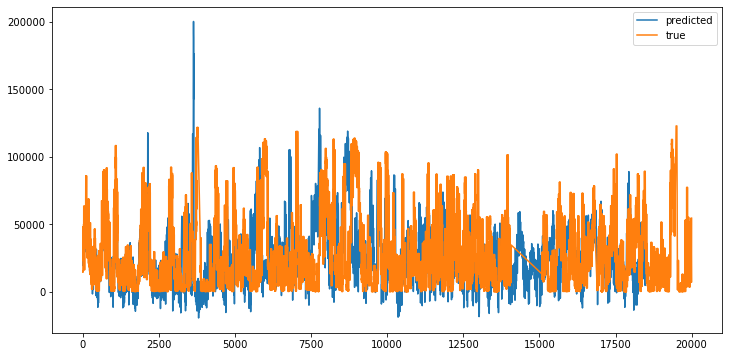

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [30]:
PreprocessingLinearModel(x_df,y_df[['power']])

In [39]:
query_kmmlds91x='''
select * from df_hive.data_o15632609593521.`kmmlds1` where masterid='ABCDE0001'  and sequence>=26852 and sequence<26875
'''
query_kmmlds91y='''
select sequence,power,speed from df_hive.data_o15632609593521.`kmmlds1` where masterid='ABCDE0001' and sequence>=26852 and sequence<26875
'''
x_df=querytables(query_kmmlds91x)
x_df.drop(['speed','power'],axis=1,inplace=True)
y_df=querytables(query_kmmlds91y)

89 (23,)


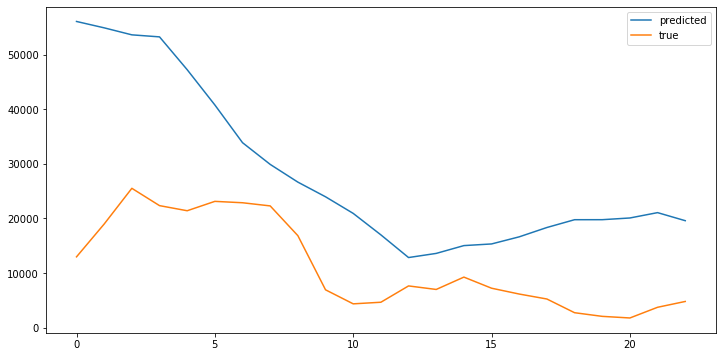

In [40]:
YY=TestLinearModel(x_df,y_df,'Linear_model.pkl')